In [37]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax
import diffrax as dfx
import matplotlib.pyplot as plt

load data

In [38]:
no_noise_data = jnp.load("../data/ODE_solution.npy")
train_data = jnp.load("../data/noisy_solutions.npy")

neural network - 1 hidden layer, 10 neurons

In [39]:
class VectorField(eqx.Module):
    layers: list

    def __init__(self, key):
        key1, key2 = jr.split(key, 2)
        self.layers = [
            eqx.nn.Linear(2, 10, use_bias=True, key=key1),
            jnp.tanh,
            eqx.nn.Linear(10, 1, use_bias=True, key=key2)
        ]

    def __call__(self, t, y, args):
        t = jnp.asarray(t)[None]
        y = jnp.concatenate([t, y])
        for layer in self.layers:
            y = layer(y)
        return y

Neural ODE

In [40]:
class NeuralODE(eqx.Module):
    vector_field: VectorField

    def __init__(self, key):
        self.vector_field = VectorField(key)

    def __call__(self, times):
        vf = dfx.ODETerm(self.vector_field)
        t0 = 0
        t1 = 9.99
        dt0 = 0.01
        saveat = dfx.SaveAt(ts=times)
        y0 = jnp.array([0.0])
        solver = dfx.Midpoint()
        sol = dfx.diffeqsolve(
            terms = vf,
            solver = solver,
            t0 = t0,
            t1 = t1,
            dt0 = dt0,
            y0 = y0,
            saveat = saveat,
            max_steps=999,
        )
        ts = sol.ts
        ys = sol.ys
        return ts, ys[:, -1]

RNG

In [41]:
SEED = 1
key = jr.key(SEED)
model_key, perm_key = jr.split(key, 2)

optimisation helpers

In [42]:
@eqx.filter_value_and_grad
def grad_loss(model, ys_data, times):
    ts, ys = model(times)
    return jnp.mean((ys_data - ys) ** 2)


@eqx.filter_jit
def make_step(model, ys_data, times, optim, opt_state):
    loss, grads = grad_loss(model, ys_data, times)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [43]:
num_data = [
    3,
    5,
    10,
    20,
    50,
    100,
    500,
    1000,
]

all_sols = []

keys = jr.split(key, len(num_data))

for idx, num in enumerate(num_data):
    print("")
    print(f"Running num_data={num}")
    print("")
    model_key, perm_key = jr.split(keys[idx], 2)
    neural_ode = NeuralODE(model_key)
    optim = optax.adam(1e-2)
    opt_state = optim.init(eqx.filter(neural_ode, eqx.is_inexact_array))
    dense_times = jnp.linspace(0, 9.9, 1000)

    training_times = jnp.linspace(0, 999, num, dtype=jnp.int32)
    steps = 1000
    perms = jr.randint(perm_key, shape=(steps,), minval=0, maxval=9)
    for step in range(steps):
        ys_data = (train_data[perms[step], :])[training_times]
        loss, neural_ode, opt_state = make_step(neural_ode, ys_data, dense_times[training_times], optim, opt_state)
        if step % 100 == 0 or step == steps - 1:
            print(f"Step: {step}, Loss: {loss}")
    
    _, ys = neural_ode(dense_times)
    all_sols.append(ys)


Running num_data=3

Step: 0, Loss: 2.358658790588379
Step: 100, Loss: 0.00039902509888634086
Step: 200, Loss: 4.358452315500472e-06
Step: 300, Loss: 0.0034979269839823246
Step: 400, Loss: 2.018681334448047e-05
Step: 500, Loss: 4.239934423821978e-05
Step: 600, Loss: 0.00046469501103274524
Step: 700, Loss: 0.002727525308728218
Step: 800, Loss: 0.0029098247177898884
Step: 900, Loss: 0.00010783728066598997
Step: 999, Loss: 0.002508272184059024

Running num_data=5

Step: 0, Loss: 15.19090747833252
Step: 100, Loss: 0.011117571964859962
Step: 200, Loss: 0.003774865297600627
Step: 300, Loss: 0.003794502466917038
Step: 400, Loss: 0.0014539783587679267
Step: 500, Loss: 0.0004013942088931799
Step: 600, Loss: 0.0006977440207265317
Step: 700, Loss: 0.0001853958092397079
Step: 800, Loss: 0.0003609820269048214
Step: 900, Loss: 0.00048395953490398824
Step: 999, Loss: 0.0012185665545985103

Running num_data=10

Step: 0, Loss: 0.8223674893379211
Step: 100, Loss: 0.0035294422414153814
Step: 200, Loss: 0

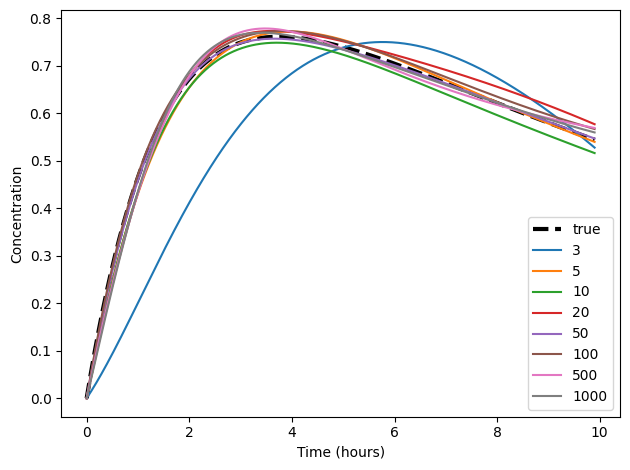

In [44]:
plt.plot(dense_times, no_noise_data, linestyle="--", color="black", linewidth=3, label="true")
for idx, num in enumerate(num_data):
    plt.plot(dense_times, all_sols[idx], label=f"{num}")
plt.xlabel("Time (hours)")
plt.ylabel("Concentration")
plt.legend()
plt.tight_layout()
plt.savefig("figures/better_sparsity_fig.png", dpi=600)
plt.show()